# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

## Reading statistics

In [2]:
#stats_file = "image_dimensions.csv"
stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 65, 70, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 33, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         253,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )

    return train_dataset, validation_dataset, test_dataset


In [7]:
def print_metrics(model, test):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")

In [8]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Data augmentation

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3,0.3)
])

In [10]:
painters = ["Rubens", "Picasso"]
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


2025-01-03 18:55:38.028882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


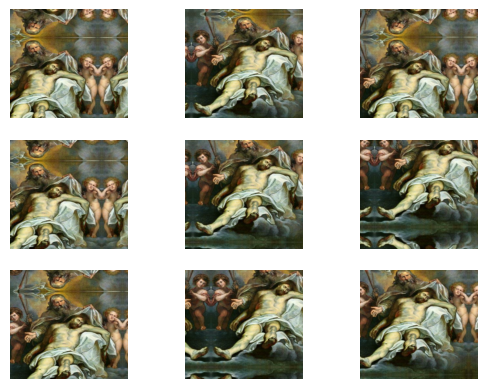

In [11]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Undersampled dataset

### Rubens en picasso

In [12]:
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


#### Model trainen zonder data augmentation

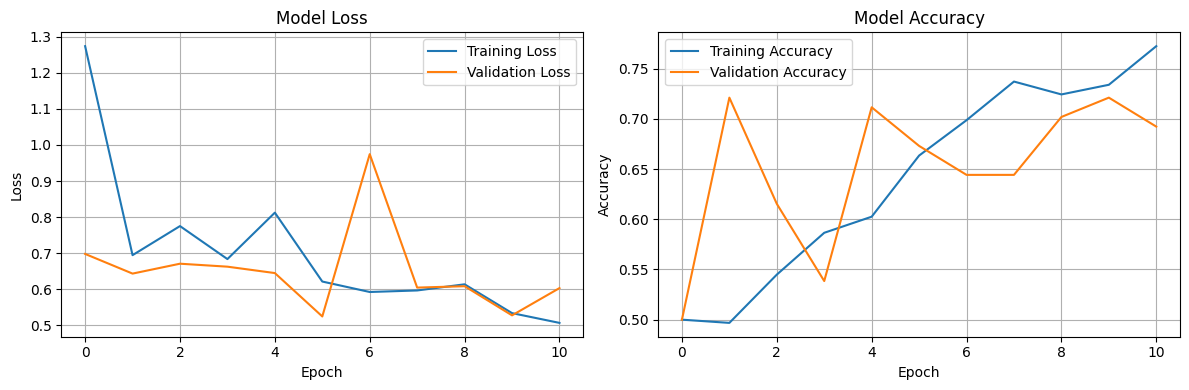

In [13]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [14]:
print_metrics(model, test)

Test Loss: 0.42804810404777527
Test Accuracy: 0.817307710647583
Test Precision: 0.8510638475418091
Test Recall: 0.7692307829856873


#### Model trainen met data augmentation

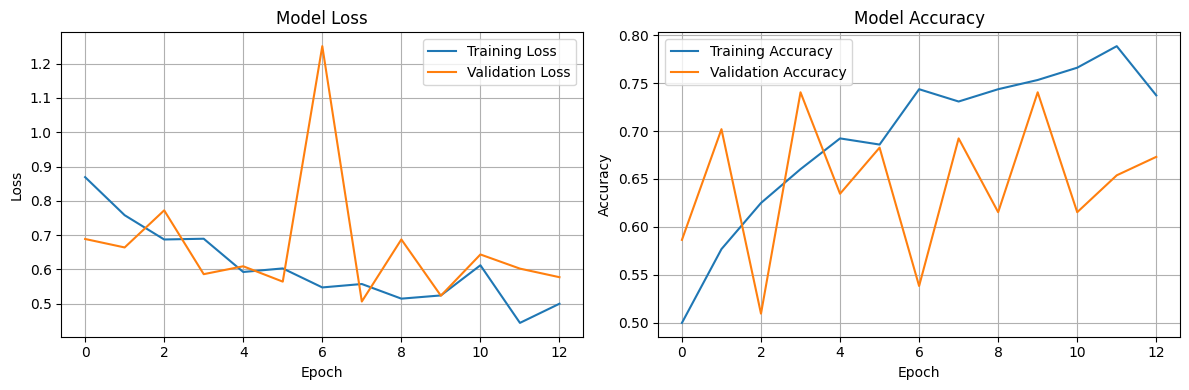

In [17]:
callbacks = [ModelCheckpoint(filepath="model_undersampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [18]:
print_metrics(model, test)

Test Loss: 0.47957658767700195
Test Accuracy: 0.8269230723381042
Test Precision: 0.8695651888847351
Test Recall: 0.7692307829856873


### Mondriaan en Rubens

In [20]:
#dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
dataset_dir = "undersampled_dataset"
painters = ["Mondriaan", "Rubens"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 312 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 104 files belonging to 2 classes.


#### Model trainen zonder data augmentation

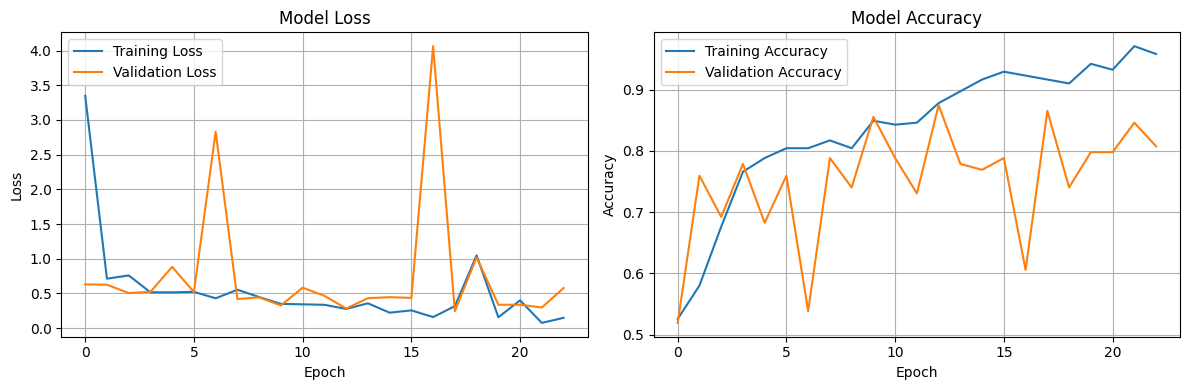

In [21]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [22]:
print_metrics(model, test)

Test Loss: 0.34216001629829407
Test Accuracy: 0.8653846383094788
Test Precision: 0.9750000238418579
Test Recall: 0.75


#### Model trainen met data augmentation

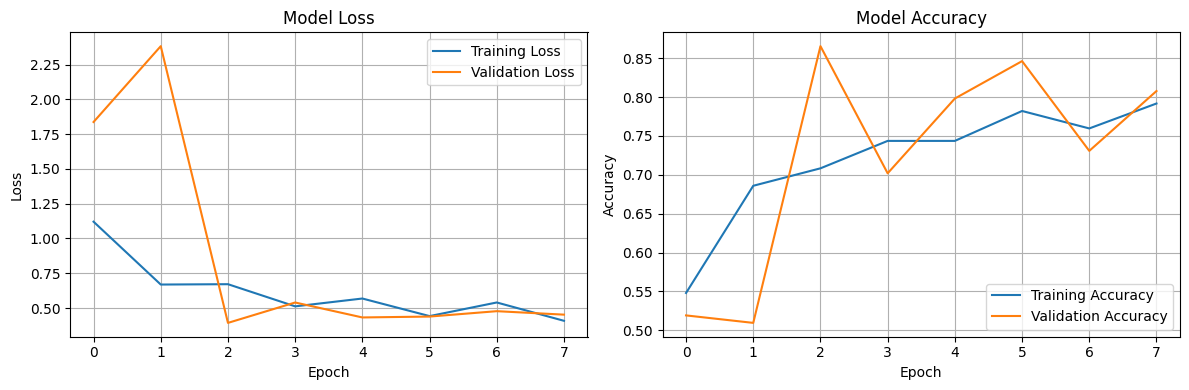

In [23]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [24]:
print_metrics(model, test)

Test Loss: 0.4175766408443451
Test Accuracy: 0.8365384340286255
Test Precision: 0.7966101765632629
Test Recall: 0.9038461446762085


## Oversampled dataset

### Rubens en picasso

In [25]:
dataset_dir = "oversampled_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

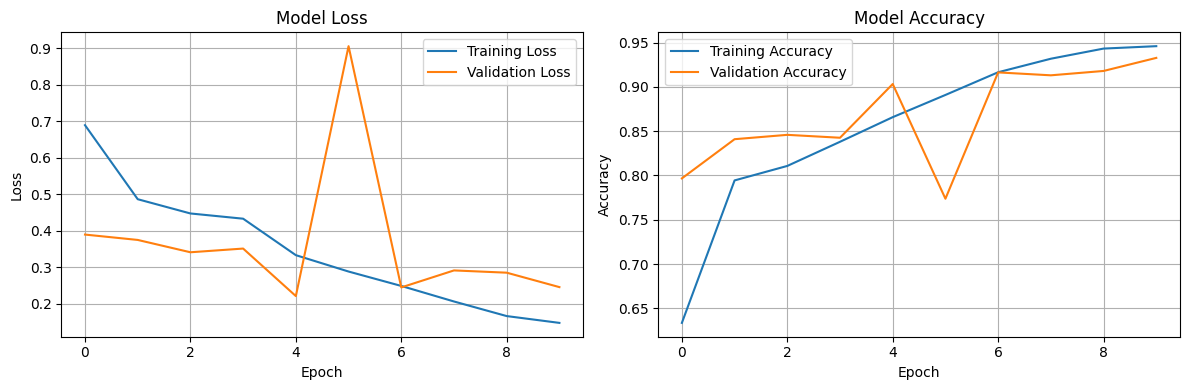

In [27]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [28]:
print_metrics(model, test)

Test Loss: 0.30825337767601013
Test Accuracy: 0.8721311688423157
Test Precision: 0.8603174686431885
Test Recall: 0.88852459192276


#### Model trainen met data augmentation

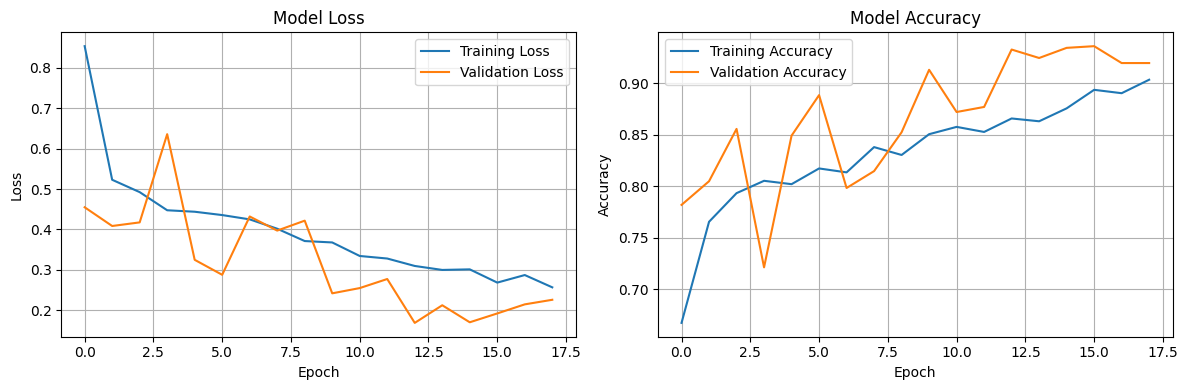

In [29]:
callbacks = [ModelCheckpoint(filepath="model_oversampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [30]:
print_metrics(model, test)

Test Loss: 0.23237985372543335
Test Accuracy: 0.9032787084579468
Test Precision: 0.9100000262260437
Test Recall: 0.8950819969177246


### Mondriaan en Rembrandt

In [9]:
dataset_dir = "oversampled_dataset"
#dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Rembrandt"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

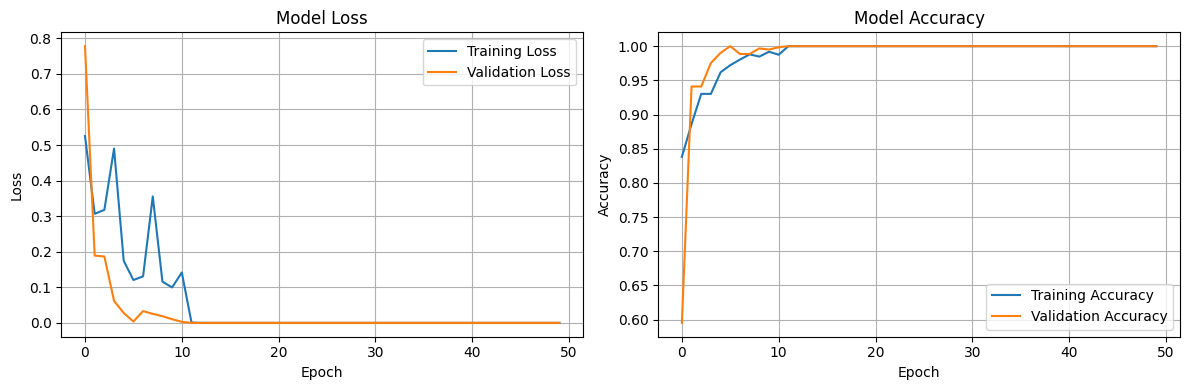

In [33]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [34]:
print_metrics(model, test)

Test Loss: 1.6098830712962808e-08
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


#### Model trainen met data augmentation

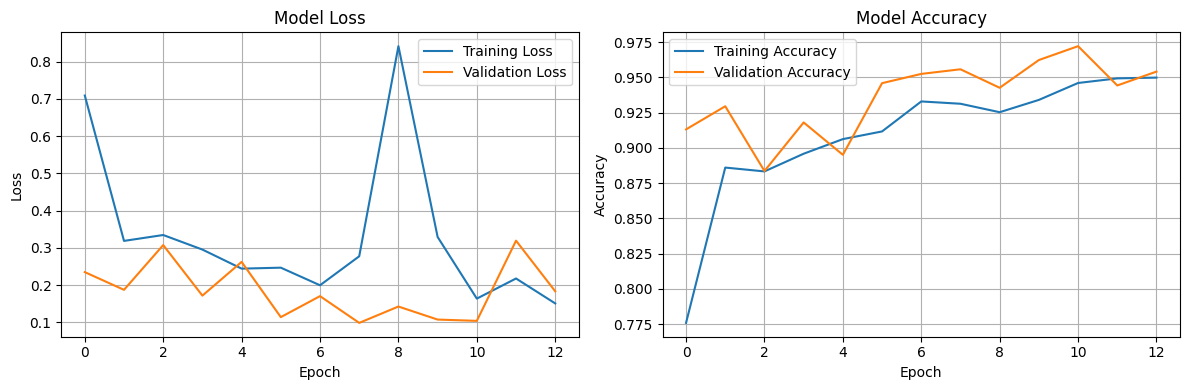

In [10]:
callbacks = [ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [11]:
print_metrics(model, test)

Test Loss: 0.08921721577644348
Test Accuracy: 0.9606557488441467
Test Precision: 1.0
Test Recall: 0.9213114976882935


## Imbalanced dataset

In [11]:
#dataset_dir = "imbalanced_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 1323 files belonging to 2 classes.
Found 444 files belonging to 2 classes.
Found 440 files belonging to 2 classes.


### Rubens en picasso

#### Class weights bepalen

In [12]:
train.class_names

['Rubens', 'Picasso']

In [13]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1323, {1: 917, 0: 406})

In [14]:
rubens_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / rubens_count) * (total / 2.0)) if rubens_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 1.6293103448275863, 1: 0.7213740458015268}

#### Baseline

In [15]:
picasso_count / total

0.6931216931216931

#### Model trainen zonder data augmentation

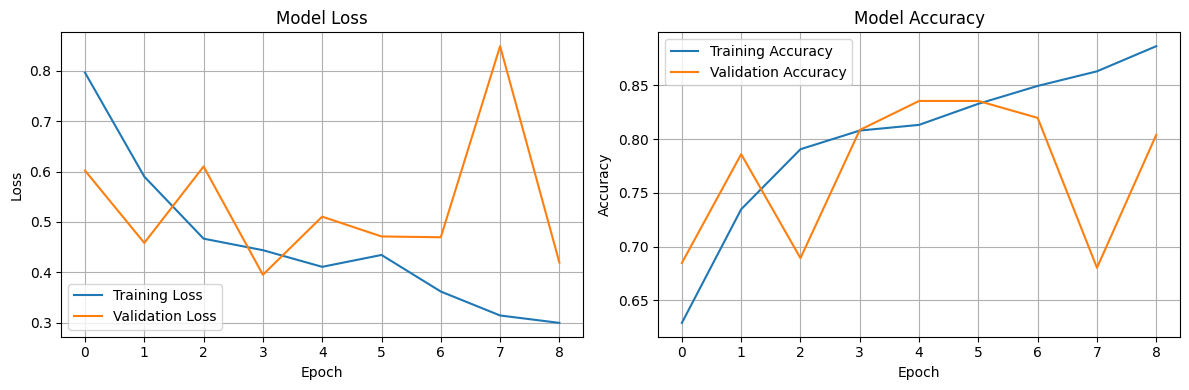

In [16]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

In [17]:
print_metrics(model, test)

Test Loss: 0.3185481131076813
Test Accuracy: 0.8613636493682861
Test Precision: 0.9420289993286133
Test Recall: 0.8524590134620667


#### Model trainen met data augmentation

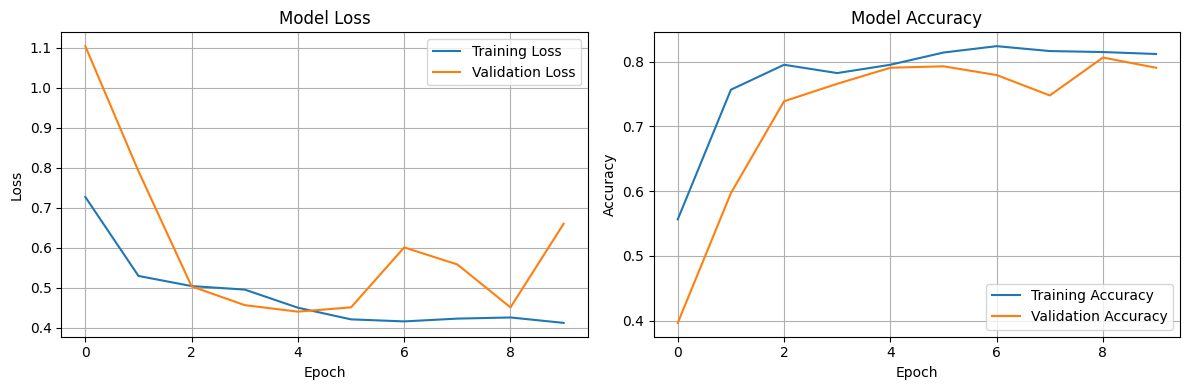

In [18]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

In [19]:
print_metrics(model, test)

Test Loss: 0.3725963532924652
Test Accuracy: 0.8613636493682861
Test Precision: 0.9420289993286133
Test Recall: 0.8524590134620667


### Mondriaan en Rembrandt

#### Data inladen

In [20]:
painters = ["Mondriaan", "Rembrandt"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 354 files belonging to 2 classes.
Found 118 files belonging to 2 classes.
Found 118 files belonging to 2 classes.


#### Class weights bepalen

In [21]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(354, {1: 156, 0: 198})

In [22]:
mondriaan_count = class_counts.get(0, 0)  
rembrandt_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / rembrandt_count) * (total / 2.0)) if rembrandt_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 0.893939393939394, 1: 1.1346153846153846}

#### Baseline

In [23]:
mondriaan_count / total

0.559322033898305

#### Model trainen zonder data augmentatie

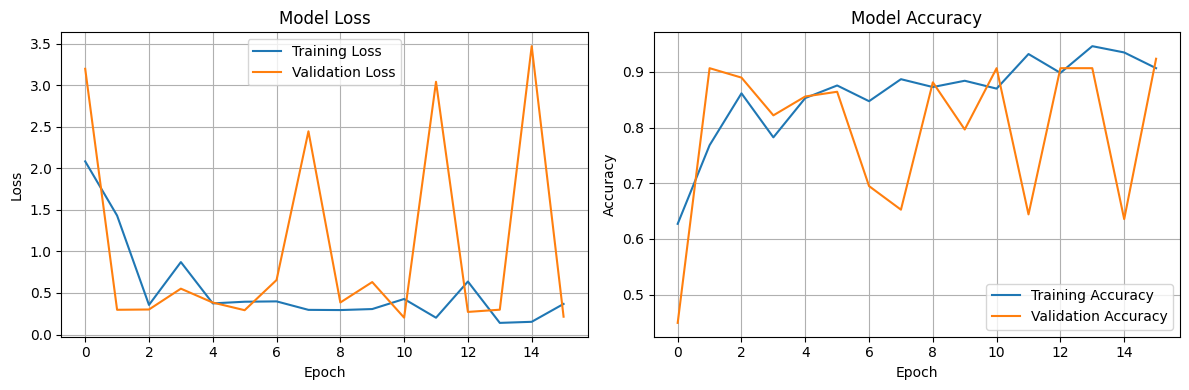

In [24]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

In [25]:
print_metrics(model, test)

Test Loss: 0.2061471790075302
Test Accuracy: 0.9237288236618042
Test Precision: 0.9387755393981934
Test Recall: 0.8846153616905212


#### Model trainen met data augmentatie

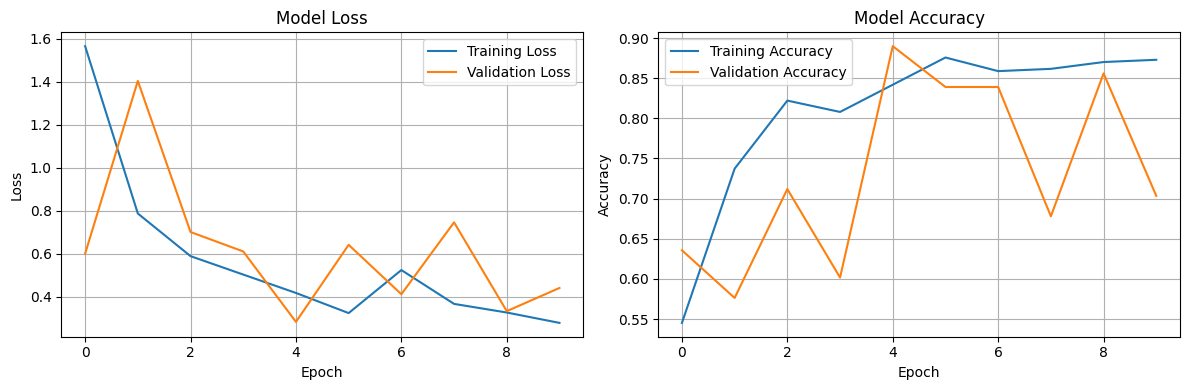

In [26]:
callbacks = [ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

In [27]:
print_metrics(model, test)

Test Loss: 0.24615733325481415
Test Accuracy: 0.8983050584793091
Test Precision: 0.9545454382896423
Test Recall: 0.807692289352417


## Image size bepalen

Grid search opsplitsen wegen RAM issues

In [7]:
def run_grid_search(statistic, dataset_dir, painters, interpolations):
    results = []

    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    
    for interpolation in interpolations:
        print(f"Processing {statistic} with interpolation: {interpolation}")

        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)

        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss"),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "epochs": len(history.history['accuracy']),
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "test_loss": test_loss,
            "precision": test_precision,
            "recall": test_recall
        })

        print(results[-1]) 

    df = pd.DataFrame(results)
    return df


In [29]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_min = run_grid_search("min", dataset_dir, painters, interpolations)
results_min.to_csv("image_size_gridsearch_result_min.csv")
results_25 = run_grid_search("25%", dataset_dir, painters, interpolations)
results_25.to_csv("image_size_gridsearch_result_25.csv")

Processing min with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'epochs': 12, 'train_accuracy': 0.9825000166893005, 'val_accuracy': 0.9075000286102295, 'test_accuracy': 0.9325000047683716, 'train_loss': 0.04044182971119881, 'val_loss': 0.5249884128570557, 'test_loss': 0.2055145800113678, 'precision': 0.9942857027053833, 'recall': 0.8700000047683716}
Processing min with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'epochs': 19, 'train_accuracy': 1.0, 'val_accuracy': 0.9599999785423279, 'test_accuracy': 0.9674999713897705, 'train_loss': 0.0018298961222171783, 'val_loss': 0.18071973323822021, 'test_loss': 0.15623165667057037, 'precision':

In [8]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]

results_mean = run_grid_search("mean", dataset_dir, painters, interpolations)
results_mean.to_csv("image_size_gridsearch_result_mean.csv")

Processing mean with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'mean', 'interpolation': 'bilinear', 'width': 603, 'height': 648, 'epochs': 14, 'train_accuracy': 0.9700000286102295, 'val_accuracy': 0.9275000095367432, 'test_accuracy': 0.925000011920929, 'train_loss': 0.2906380891799927, 'val_loss': 0.4545263648033142, 'test_loss': 0.23079898953437805, 'precision': 0.9670329689979553, 'recall': 0.8799999952316284}
Processing mean with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'mean', 'interpolation': 'nearest', 'width': 603, 'height': 648, 'epochs': 15, 'train_accuracy': 0.9941666722297668, 'val_accuracy': 0.8550000190734863, 'test_accuracy': 0.9150000214576721, 'train_loss': 0.0360800102353096, 'val_loss': 1.51973557472229, 'test_loss': 0.32081782817840576, 

In [9]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"]
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"
painters = ["Mondriaan", "Picasso"]
results_median = run_grid_search("median", dataset_dir, painters, interpolations)
results_median.to_csv("image_size_gridsearch_result_median.csv")

Processing median with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'median', 'interpolation': 'bilinear', 'width': 550, 'height': 590, 'epochs': 15, 'train_accuracy': 0.9891666769981384, 'val_accuracy': 0.9375, 'test_accuracy': 0.9275000095367432, 'train_loss': 0.0567040890455246, 'val_loss': 0.5648768544197083, 'test_loss': 0.18344077467918396, 'precision': 0.9130434989929199, 'recall': 0.9449999928474426}
Processing median with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': 'median', 'interpolation': 'nearest', 'width': 550, 'height': 590, 'epochs': 14, 'train_accuracy': 0.9783333539962769, 'val_accuracy': 0.8974999785423279, 'test_accuracy': 0.9225000143051147, 'train_loss': 0.10499000549316406, 'val_loss': 0.6643427014350891, 'test_loss': 0.30776891112327576, 

In [11]:
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5"] 
dataset_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset" 
painters = ["Mondriaan", "Picasso"] 
results_75 = run_grid_search("75%", dataset_dir, painters, interpolations) 
results_75.to_csv("image_size_gridsearch_result_75.csv")

Processing 75% with interpolation: bilinear
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': '75%', 'interpolation': 'bilinear', 'width': 800, 'height': 826, 'epochs': 18, 'train_accuracy': 0.9883333444595337, 'val_accuracy': 0.9649999737739563, 'test_accuracy': 0.9350000023841858, 'train_loss': 0.09796744585037231, 'val_loss': 0.5347765684127808, 'test_loss': 0.3431151509284973, 'precision': 0.9438775777816772, 'recall': 0.925000011920929}
Processing 75% with interpolation: nearest
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'statistic': '75%', 'interpolation': 'nearest', 'width': 800, 'height': 826, 'epochs': 13, 'train_accuracy': 0.9800000190734863, 'val_accuracy': 0.9175000190734863, 'test_accuracy': 0.9300000071525574, 'train_loss': 0.09556552022695541, 'val_loss': 0.4903034567832947, 'test_loss': 0.18846984207630157, '

In [2]:
gridsearch_dir = "/kaggle/input/image-size-gridsearch-result"
prefix = "image_size_gridsearch_result"
df_min = pd.read_csv(f"{gridsearch_dir}/{prefix}_min.csv")
df_25 = pd.read_csv(f"{gridsearch_dir}/{prefix}_25.csv")
df_mean = pd.read_csv(f"{gridsearch_dir}/{prefix}_mean.csv")
df_median = pd.read_csv(f"{gridsearch_dir}/{prefix}_median.csv")
df_75 = pd.read_csv(f"{gridsearch_dir}/{prefix}_75.csv")
dataframes = [df_min, df_25, df_mean, df_median, df_75]
df = pd.concat(dataframes)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
0,min,bilinear,106,108,12,0.982500,0.9075,0.9325,0.040442,0.524988,0.205515,0.994286,0.870
1,min,nearest,106,108,19,1.000000,0.9600,0.9675,0.001830,0.180720,0.156232,1.000000,0.935
2,min,bicubic,106,108,12,0.984167,0.8625,0.9350,0.037810,0.655840,0.202600,0.953125,0.915
3,min,area,106,108,15,1.000000,0.9525,0.9575,0.003327,0.235195,0.134755,1.000000,0.915
4,min,lanczos3,106,108,18,0.987500,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950


In [3]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
4,min,lanczos3,106,108,18,0.987500,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950
6,25%,gaussian,314,383,16,0.966667,0.9275,0.9725,0.166130,0.385534,0.116675,0.989637,0.955
1,min,nearest,106,108,19,1.000000,0.9600,0.9675,0.001830,0.180720,0.156232,1.000000,0.935
2,25%,bicubic,314,383,15,0.989167,0.8050,0.9650,0.059487,1.681904,0.108875,0.969697,0.960
5,25%,lanczos5,314,383,16,0.981667,0.9550,0.9650,0.093961,0.378558,0.114040,0.979381,0.950


In [4]:
df.sort_values("precision", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
3,min,area,106,108,15,1.000000,0.9525,0.9575,0.003327,0.235195,0.134755,1.000000,0.915
5,median,lanczos5,550,590,18,0.986667,0.9025,0.9275,0.064628,0.752033,0.392161,1.000000,0.855
1,min,nearest,106,108,19,1.000000,0.9600,0.9675,0.001830,0.180720,0.156232,1.000000,0.935
4,min,lanczos3,106,108,18,0.987500,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950
3,75%,area,800,826,16,0.985000,0.9300,0.9575,0.176194,0.938487,0.224285,0.994595,0.920


In [5]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
4,25%,lanczos3,314,383,15,0.985000,0.8850,0.9475,0.036260,0.771011,0.163805,0.920188,0.980
2,25%,bicubic,314,383,15,0.989167,0.8050,0.9650,0.059487,1.681904,0.108875,0.969697,0.960
6,25%,gaussian,314,383,16,0.966667,0.9275,0.9725,0.166130,0.385534,0.116675,0.989637,0.955
4,min,lanczos3,106,108,18,0.987500,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950
5,25%,lanczos5,314,383,16,0.981667,0.9550,0.9650,0.093961,0.378558,0.114040,0.979381,0.950


In [6]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
1,min,nearest,106,108,19,1.0000,0.9600,0.9675,0.001830,0.180720,0.156232,1.000000,0.935
4,min,lanczos3,106,108,18,0.9875,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950
6,min,gaussian,106,108,14,0.9900,0.9300,0.9225,0.035499,0.195340,0.237749,0.961749,0.880
3,min,area,106,108,15,1.0000,0.9525,0.9575,0.003327,0.235195,0.134755,1.000000,0.915
5,mean,lanczos5,603,648,13,0.9850,0.9300,0.8950,0.059405,0.238315,0.250550,0.987654,0.800


In [7]:
df.to_csv("image_size_gridsearch_result.csv")